# Psi method 

## Explination

The Psi method is an adaptive method to estimate the threshold and slope of a psychometric function using Bayesian estimation. Most of the concepts in this notebook is taken from Kontesevich and Tyler 1997 from Vision Research. 

The threshold of the psychometric function, denoted by $\alpha$, is the inflection point of the function, or the point at wich the response is 50/50 (in this specific case). It represents the bias in the estimates. The slope, denoted by $\beta$, reflects the uncertainty in the estimate.

The Psi method is an adaptive method in that the next stimulus is selected based on the previous response(s). This is in constrast to the method of constant stimuli which provides the same stimuli a pre-set number of times. Adaptive methods need to address three main considerations:
1. Estimate of psychometric parameters
2. The termination rule
3. Placement of the next trial

1. **Estimate the psychometric parameters ($\alpha$ and $\beta$)**

    The most efficient way to obtain these estimates is to use Bayesian estimation. First, we define the 2-d prior by making an initial guess for each of the parameters:
    
    $p(\alpha, \beta)$
    
    Then, after the response, $r$, we calculate the probability of all prior responses, given each set of parameter values:
    
    $p(r | \alpha, \beta)$
    
    Multiplying these distributions together yields the posterior distribution of all possible parameter values:
    
    $p(\alpha, \beta | r)$

    The mean of this distribution is the best estimate of the parameters because it minimizes the variance of the threshold and is more stable than using the maximum a posteri. 

    The posterior then becomes the prior for the next trial, and the process repeats until the test is terminated. 

2. **Termination rule**

    There are several different options, for simplicity, we plan on stopping after a certain number of trials

3. **Placement of the next trial**

    This is where the psi algorithm really does its work. To estimate threshold the most optimal location for the next stimulus is at the current threshold estimate, for the slope, it is slightly above and below the stimulus (in general). But, what specific stimulus should we choose? 
    
    Before each trial, the Psi algorithm simulates over every possible stimulus location for the next trial, $x$, calculating a posterior distribution for both possible responses at each $x$. Then, it calculates the Information Entropy ($H$) for each stimulus location ($H(x)$). The next stimulus is the one that minimizes the entropy" $\underset{x}{argmin}(H(x))$
    
    Information entropy is the amount of uncertainty in the distribution. Moving from an uncertain distribution to one with more certinaty increases the amount of infomration we can gain from one trial to the next. For example, the weather forcast in Newark, DE 7 days from now is 61 and cloudy. There is uncertainty in this prediction, but when that day comes, there will be no uncertainty. Therefore, we have gained information about the weather. 
    
    Information entroy is calculated as the probability times the log probability:
    
    $H = - \sum{p * log(p)}$

## Define Functions

### Look up table

First, we need to define a look-up table to speed up the method. This look-up table contains conditional probabilities of both possible responses given the parameter values and the stimulus location:

$p(r| \alpha,\beta,x)$

This probability is defined by:

$p(r=left | \alpha,\beta,x) = \Psi_{\alpha,\beta}(x)$

$p(r=right | \alpha,\beta,x) = 1-\Psi_{\alpha,\beta}(x)$

In [1]:
#Import python notebooks
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.stats import norm
from numpy.random import random

ModuleNotFoundError: No module named 'numpy'

In [57]:
def Psi_lookT(X,a_range,b_range):
    """
    This function creates two lookup tables required for the psi algorithm to run more efficiently
    It is a table of probabilities for both responses (left and right in this case) given all possible
    alpha and beta values and all possible stimulus locations:
    p(r='left'|alpha,beta,X)
    p(r='right'|alpha,beta,X)
    """
    #Set these nuisance parameters to nonzero values
    gam = 0.02
    lam = 0.02
    
    #Preallocate the lookup tables
    p_left_look = np.empty([len(b_range),len(a_range),(len(X))])
    p_right_look = np.empty([len(b_range),len(a_range),(len(X))])
    
    #Loop through all possible stimulus, alpha and beta values
    for x_i, x in enumerate(X):
        for a_i, a in enumerate(a_range):
            for b_i, b in enumerate(b_range):
                psi = gam + (1 - lam - gam) * norm.cdf(x,a,b)
                p_left_look[b_i,a_i,x_i] = psi
                p_right_look[b_i,a_i,x_i] = 1-psi

    return p_left_look, p_right_look

### Entropy function

Here we calculate the entropy for each possible stimulus value, x

In [64]:
#Entropy function
def CalcH(X, p_left_look, p_right_look, Prior):

    """
    This function calculates the entropy (H) of each possible stimulus value to determine which one minimizes,
    the entropy for the next trial. This is the stimulus that will provide the most information for both parameters
    """
    
    #Simulate through each possible stim value, X
    H = []
    for x in range(len(X)):

        #Calculate the probability of getting a response, r, after presenting test x at the next trial (across all possible parameter values)
        p_left = np.nansum(np.nansum(np.multiply(p_left_look[:,:,x],Prior)))
        p_right = np.nansum(np.nansum(np.multiply(p_right_look[:,:,x],Prior)))

        #Calculate the posterior for each response 
        Post_left = np.multiply(Prior,p_left_look[:,:,x])
        Post_left = np.divide(Post_left, np.nansum(np.nansum(Post_left)))
        Post_right = np.multiply(Prior,p_right_look[:,:,x])
        Post_right = np.divide(Post_right, np.nansum(np.nansum(Post_right)))

        #Estimate the entropy of the posterior distribution for each response
        H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
        H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
        
        #Combine the entropy calculations, weighted by their probabilities
        Total_H = (H_left*p_left) + (H_right*p_right)
        H.append(Total_H)
    
    H = np.array(H)
    return H

### Psi simulation function

Here we define the psi function 

In [62]:
def PSIsim(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look):
    
    """
    Simulate the Psi algorithm with the number of trials and the given parameters (params),
    Need to also input the range of possible alpha and beta values, the prior and the lookup tables
    """

    #Define the parameters
    alpha = params[0]
    beta = params[1]
    lam = params[2]
    gam = params[3]
    
    #initialize 
    stims = np.empty(Ntrials)
    responses = np.empty(Ntrials)
    alpha_EV = np.empty(Ntrials)
    beta_EV = np.empty(Ntrials)
    
    #Start the experiment
    for t in range(Ntrials):
        print(t)
        
        #First simulate through each possible stim value, X, and calculate entropy
        H = CalcH(X, p_left_look, p_right_look, Prior)
        stim = X[np.argmin(H)]
        stims.append(stim)
        plt.figure()
        plt.plot(X,H)
        print(stims[t])
        
        #Participant makes a selection
        P_left = gam + (1 - lam - gam)*norm.cdf(stims[t],alpha,beta)
        responses[t] = P_left > np.random.rand()
        print(responses[t])
        
        #Account for repeated stimuli 
        Unique_stims, stim_idx = np.unique(stims, return_index=True)
        Unique_stims = stims[np.sort(stim_idx)]
        Nstims = np.empty(len(Unique_stims))
        Kleft = np.empty(len(Unique_stims))
        for u, s in enumerate(Unique_stims):
            stim_idx = np.argwhere(s==stims)
            stim_idx = stim_idx[:,0]
            Nstims[u] = len(stim_idx)
            Kleft[u] = np.sum(responses[stim_idx]) 
            
        #Calcualte the likelihood for the response given the current parameters
        Likelihood = np.empty((len(a_range),len(b_range)))
        for a_i, a in enumerate(a_range):
            for b_i, b in enumerate(b_range):
                psi = gam + (1 - lam - gam)*norm.cdf(Unique_stims,a,b)
                Likelihood[a_i,b_i] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))
        
        #Calculate the posterior
        Posterior = Likelihood*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))
        
        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=1)
        beta_post = np.nansum(Posterior,axis=0)
        
        #Calculate the expected value of each
        alpha_EV[t] = np.nansum(a_range*alpha_post) 
        beta_EV[t] = np.nansum(b_range*beta_post)
        
        #The posterior becomes the prior for the next trial
        Prior = Posterior
        
    return alpha_EV, beta_EV, stims, responses, Posterior

## Simulate

### Single participant simulation

In [58]:
#Define the stimulus range
X = np.arange(-50,51)
a_range = np.arange(-50,51)
b_range = np.arange(0,101)

In [59]:
#Create the lookup tables
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in long_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in long_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Sum of prior =  1.0


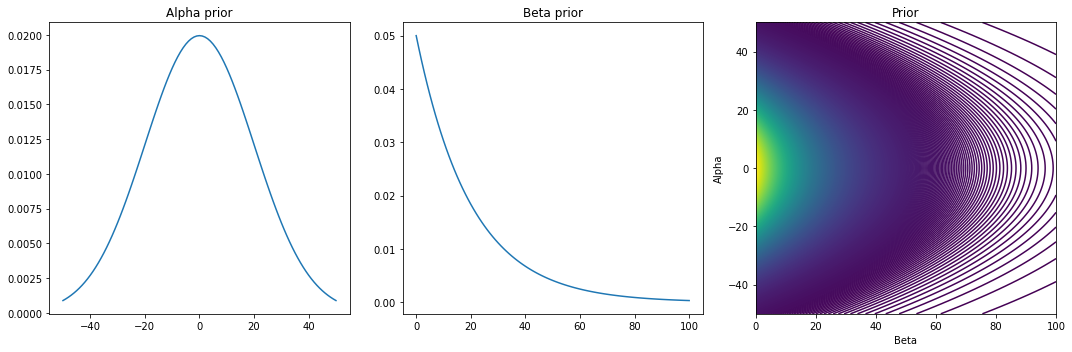

In [18]:
#Set the priors
p_alpha = norm.pdf(a_range,0,20)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
p_beta = np.reshape(p_beta,(len(p_beta),1))

#Create the 2d prior and make sure it sums to 1
Prior = p_alpha @ p_beta.T
Prior = Prior/np.nansum(np.nansum(Prior))

print('Sum of prior = ', sum(sum(Prior)))

#Plot
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(a_range,p_alpha)
plt.title('Alpha prior')
plt.subplot(1,3,2)
plt.plot(b_range,p_beta)
plt.title('Beta prior')
plt.subplot(1,3,3)
plt.contour(b_range,a_range,Prior,1000)
plt.title('Prior')
plt.ylabel('Alpha')
plt.xlabel('Beta')
plt.tight_layout()
plt.show()

0
-8.0
0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


1
-8.0
0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


2
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

3
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

4
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

5
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

6
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

7
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

8
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

9
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

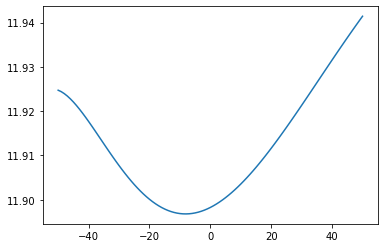

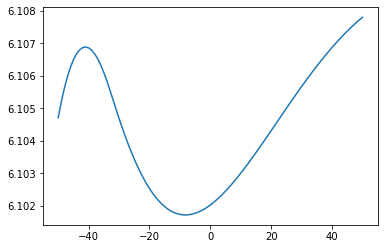

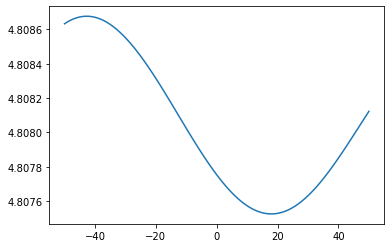

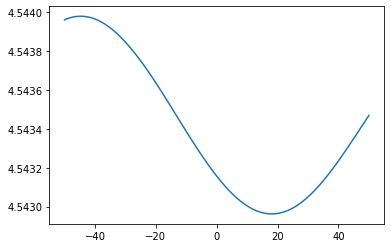

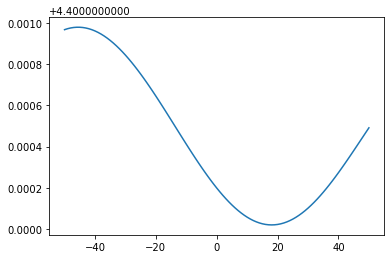

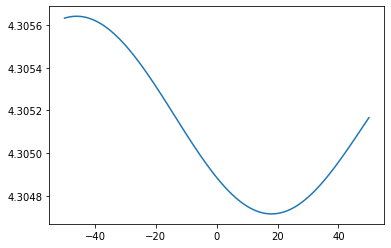

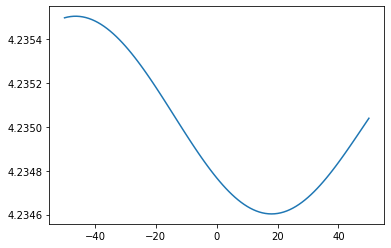

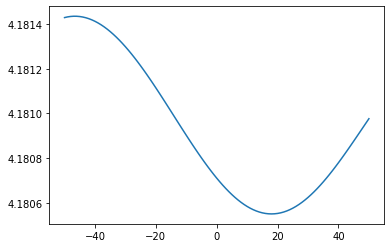

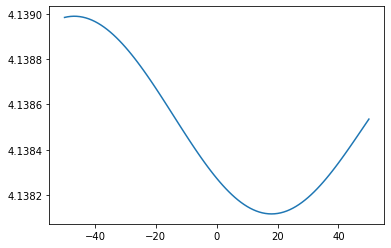

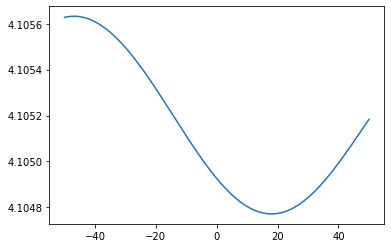

In [63]:
#Set some values for the expeirment
Ntrials = 10
#Set the parameters
alpha_sim = norm.rvs(0,10)
beta_sim = expon.rvs(0.01,20)
params = [alpha_sim,
          beta_sim, 
          0.02, 
          0.02]

#Stimulate
alpha_EV, beta_EV, stims, responses, Posterior = PSIsim(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look)

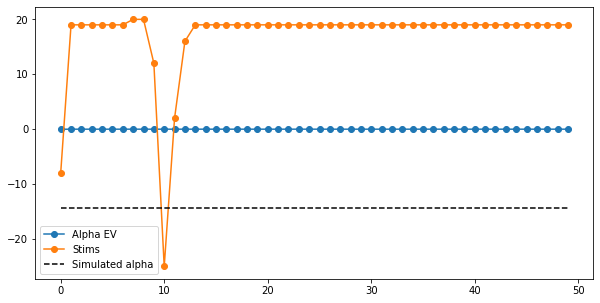

In [21]:
#Plot
plt.figure(figsize=(10,5))
plt.plot(alpha_EV,'o-',label='Alpha EV')
plt.plot(stims,'o-',label='Stims')
plt.plot(np.ones(len(alpha_EV))*alpha_sim,'k--',label='Simulated alpha')
plt.legend()
plt.show()

Locator attempting to generate 1001 ticks ([0.0, ..., 1.0]), which exceeds Locator.MAXTICKS (1000).


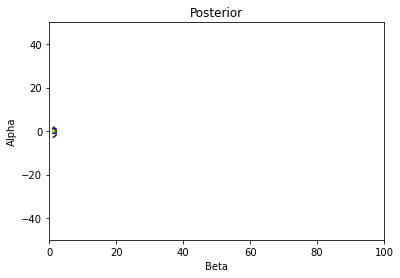

In [22]:
plt.contour(b_range,a_range,Posterior,1000)
plt.title('Posterior')
plt.ylabel('Alpha')
plt.xlabel('Beta')
plt.show()

In [33]:
EA = np.empty(10)
sum(EA)

0.0